In [7]:
# a script to deluineate the differences between the cell lines on the different time points

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import requests
plt.rcParams['svg.fonttype'] = 'none'
gene_enrichment = pd.read_csv("gene_enrichment.csv", delimiter=";")

In [6]:
# get the enriched genes pathways
import requests


def mirna_analysis_go_div(diana_df, species, cluster=None):
    # diana_dictionary == output von diana_only mirnas bzw. eigener DataFrame,
    # col_name is der Name der Column, die die Gene beinhaltet
    # sources = sind die sources die man gerne erhalten möchte als Liste bspw. ["GO"] wären alle Termen
    # ["GO:BP"] wäre einzig und allein Biological Process
    # KEGG ist ein optionaler parameter der angegeben kann wenn man auch an KEGG Pathways interessiert ist
    go_profiler = {}
    df_go_end = pd.DataFrame()
    if cluster != None:
        for i in sorted(set(diana_df[cluster].tolist())):
            diana_df_end = diana_df.loc[diana_df[cluster] == i]
            protein_list = list(set(diana_df_end["genes"].tolist()))
            print(len(protein_list))

            r = requests.post(
                url='https://biit.cs.ut.ee/gprofiler/api/gost/profile/',
                json={
                    'organism': species,
                    'query': protein_list,
                    'sources': ["GO:BP", "GO:MF", "GO:CC", "KEGG"],
                },
                headers={'User-Agent': 'FullPythonRequest'})
            try:
                data = r.json()["result"]
                parents_list = []
                go_list = []
                p_value = []
                desc_value = []
                source_list = []
                for n in data:
                    go_list.append(n["native"])
                    for t in n["parents"]:
                        parents_list.append(t)
                end_list = [i for i in go_list if i not in parents_list]
                for m in data:
                    if m["native"] in end_list:
                        p_value.append(m["p_value"])
                for l in data:
                    if l["native"] in end_list:
                        desc_value.append(l["name"])
                for l in data:
                    if l["native"] in end_list:
                        source_list.append(l["source"])
                go_profiler.update({
                    "p-value": p_value,
                    "go-terms": end_list,
                    "description": desc_value,
                    "source": source_list
                })
                df_go = pd.DataFrame(
                    columns=["go-terms", "description", "source", "p-value"])
                df_go["go-terms"] = list(end_list)
                df_go["description"] = desc_value
                df_go["source"] = source_list
                df_go["p-value"] = p_value
                df_go["cluster"] = df_go.shape[0] * [str(i)]
                df_go_end = df_go_end.append(df_go)

            except KeyError as e:
                pass

    #df_go_end.to_excel("signed_go_enrichment_analysis_filtered.xlsx")
    return (df_go_end)


day_enrichment = mirna_analysis_go_div(gene_enrichment, "hsapiens", "day")

5667
4994
6008
6710
4629
8355


In [54]:
day_enrichment.to_csv("Day_to_day_enrichments.csv")

Day 16
Day 5
Day 9
Day 36
Day 26
Day 0


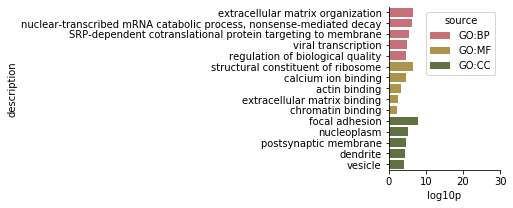

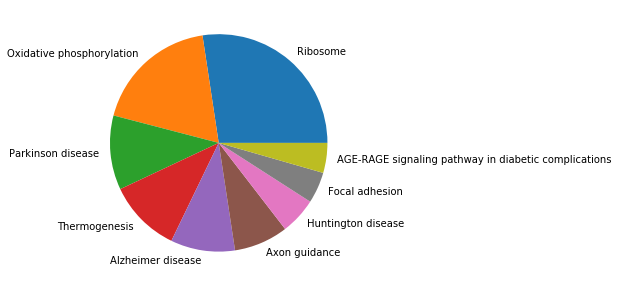

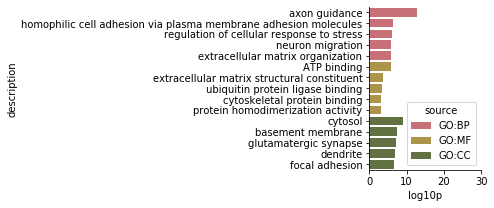

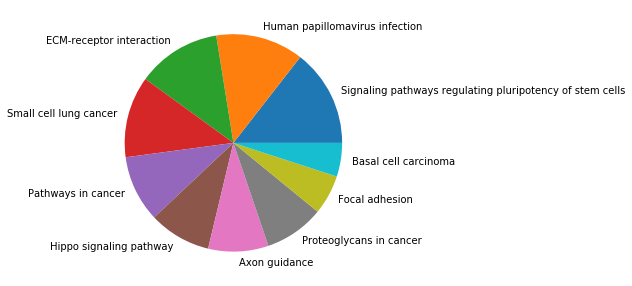

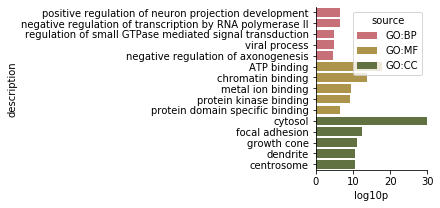

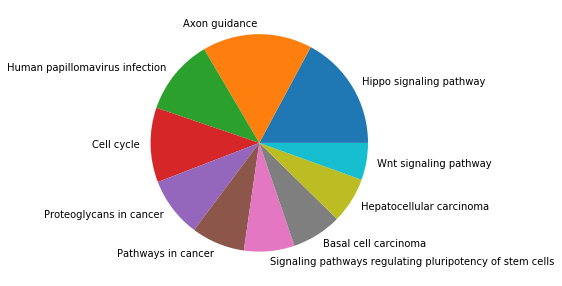

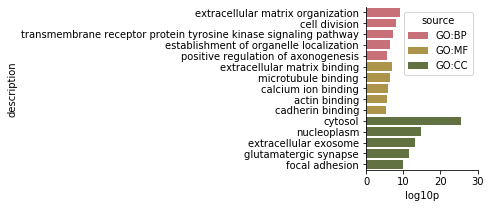

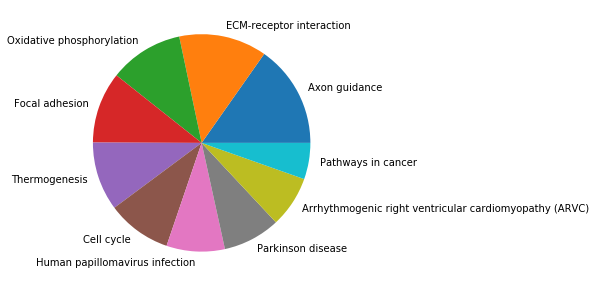

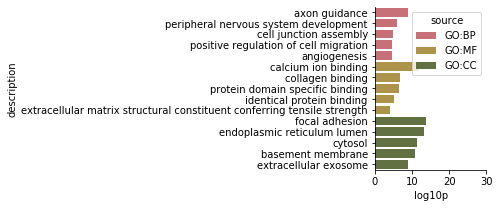

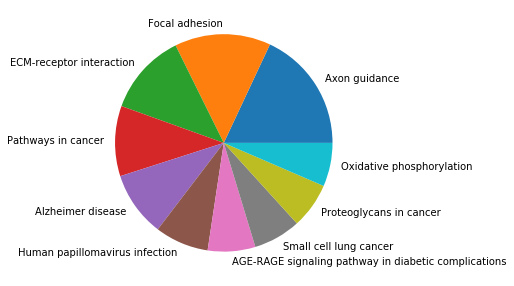

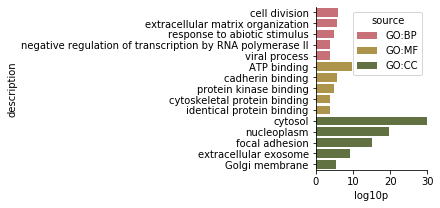

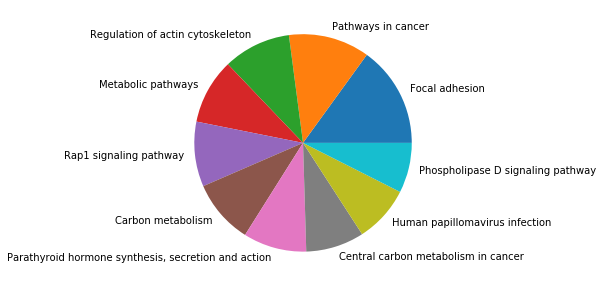

In [11]:
import numpy as np


def visualize_enrichment(mirna_output):
    cmap = plt.cm.get_cmap('tab20b_r')
    for i in set(mirna_output["cluster"]):
        print(i)
        enrichment = mirna_output[mirna_output["cluster"] == i]
        go_bp = enrichment[enrichment["source"] == "GO:BP"].sort_values(
            "p-value", ascending=True).iloc[:5, :]
        go_mf = enrichment[enrichment["source"] == "GO:MF"].sort_values(
            "p-value", ascending=True).iloc[:5, :]
        go_cc = enrichment[enrichment["source"] == "GO:CC"].sort_values(
            "p-value", ascending=True).iloc[:5, :]
        go_kegg = enrichment[enrichment["source"] == "KEGG"].sort_values(
            "p-value", ascending=True).iloc[:10, :]
        go_kegg["log10p"] = go_kegg["p-value"].apply(lambda x: -(np.log10(x)))
        gesamt = pd.concat([go_bp, go_mf, go_cc])
        gesamt["log10p"] = gesamt["p-value"].apply(lambda x: -(np.log10(x)))
        fig, ax = plt.subplots(figsize=(2, 3))
        sns.despine()
        sns.barplot(y="description",
                    x="log10p",
                    hue="source",
                    data=gesamt,
                    dodge=False,
                    palette="tab20b_r")
        plt.title(str(i))
        plt.xlim(0, 30)
        plt.title("")
        plt.savefig(str(i) + "_day_2_day_mirna_enrichment.svg",
                    quality=90,
                    transparent=True,
                    dpi=600,
                    bbox_inches="tight")
        fig2, ax2 = plt.subplots(figsize=(5, 5))
        plt.pie(go_kegg["log10p"], labels=go_kegg["description"])
        plt.savefig(str(i) + "_day_2_day_mirna_kegg.svg",
                    quality=90,
                    transparent=True,
                    dpi=600,
                    bbox_inches="tight")


visualize_enrichment(day_enrichment)

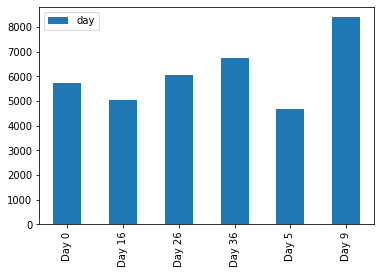

In [50]:
def barplot(df):
    counts = pd.DataFrame(df["day"].value_counts()).sort_index()
    counts.plot(kind = "bar")
    plt.savefig("Number_of_dysregulated_genes.svg", quality = 90, dpi = 600, transparent = True)
barplot(gene_enrichment)

GO:BP
       go-terms                                        description source  \
5    GO:0051301                                      cell division  GO:BP   
6    GO:0030198                  extracellular matrix organization  GO:BP   
9    GO:0009628                       response to abiotic stimulus  GO:BP   
15   GO:0000122  negative regulation of transcription by RNA po...  GO:BP   
20   GO:0016032                                      viral process  GO:BP   
..          ...                                                ...    ...   
240  GO:0007519                 skeletal muscle tissue development  GO:BP   
242  GO:2001234  negative regulation of apoptotic signaling pat...  GO:BP   
243  GO:0030010                     establishment of cell polarity  GO:BP   
245  GO:0030518  intracellular steroid hormone receptor signali...  GO:BP   
246  GO:0016241                       regulation of macroautophagy  GO:BP   

          p-value cluster  
5    9.055935e-07   Day 0  
6    1.462575

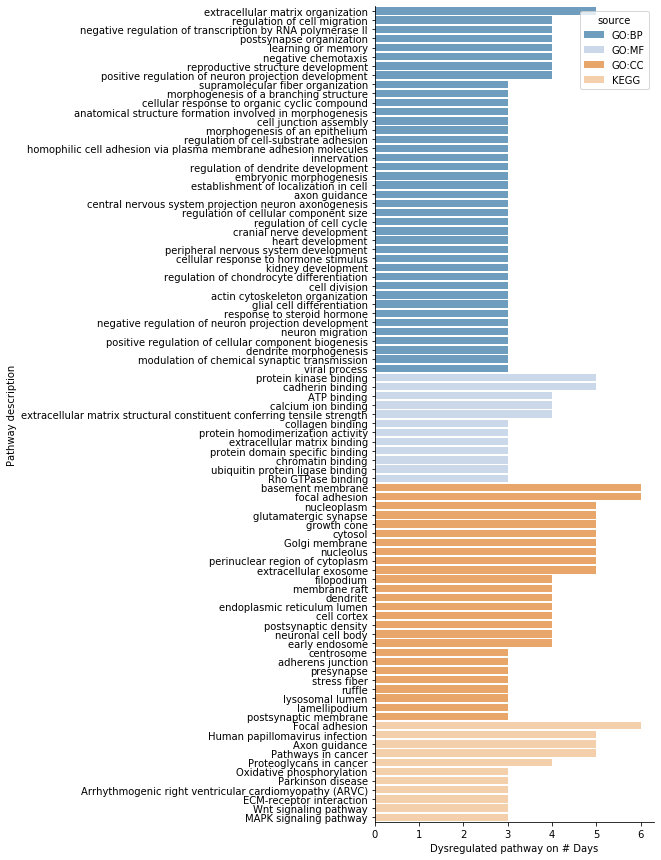

In [52]:
def barplot(df):
    count = pd.DataFrame()
    for i in set(df["source"]):
        print(i)
        df_end = df[df["source"] == i]
        print(df_end)
        counts = pd.DataFrame(df_end["description"].value_counts())
        counts["source"] = counts.shape[0]*[str(i)]
        counts = counts[counts["description"]>=3]
        count = count.append(counts)
    return count
counting = barplot(day_enrichment)
counting = counting.reset_index()
counting
fig,ax = plt.subplots(figsize = (5,15))
sns.despine()
sns.barplot(x = "description", y = "index", hue = "source", data = counting, dodge = False, palette = "tab20", alpha = 0.7)
plt.xlabel("Dysregulated pathway on # Days")
plt.ylabel("Pathway description")
plt.savefig("Number_of_shared_dysregulated_pathways.svg", quality = 90, dpi = 600, transparent = True, bbox_inches = "tight")